# Optimal control of room temperature using harvesting powered sensors

The goal is to control the room temperature by changing the heater power. Current temperature is measured by a wireless sensor. The sensor has a harvesting element to extract light energy from the environment and store it in a rechargeable battery for future use. If the sensor transmits its measurements (it uses some energy for this), then the controller obtains recent data which improves the system performance. If at a certain time slot, the sensor decides not to transmit, it saves more energy, but the controller does not update its information and worsens the performance. The goal is to find a suitable transmission policy providing both an acceptable quality of control and efficient energy consumption.

In [1]:
import Bellman as bm
import numpy as np

## Initialization

Set the desired temperature, the initial temperature in the room, the initial level of the battery, final time of simulation, and a sampling step, i.e., how often the sensor should transmit data to the controller.

In [2]:
desired_temperature = 22 #degree Celsius
initial_temperature = 12 #degree Celsius
initial_battery_level = 100 #the maximum level is 1000 (units)
final_time = 5*24 #simulation time, in hours = days * 24
sampling_step = 10 / 60 #sampling step, in hours = min / 60

#create a Model object
system = bm.Model(sampling_step,initial_temperature,initial_battery_level,desired_temperature)

We created an object *system* of the class *Model* that describes the dynamical system of room temperature, the battery model, and the stochastic models for harvesting and transmission energy.

## Simulation

Let us start with a **random policy** where the probability of transmission is **90%**. High probability means that the sensor will transmit very often, but it will spend a lot of energy.

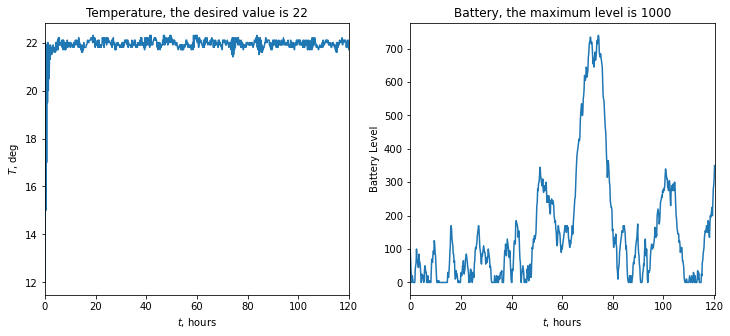

In [3]:
sampling_interval, X, Battery, Harvested_Energy, Transmission_Energy = system.simulate_with_random_policy(0.9,final_time)

system.draw_temperature_battery(sampling_interval,X,Battery,
                         title1 = 'Temperature, the desired value is 22', 
                         title2 = 'Battery, the maximum level is 1000',
                         xlabel1 = '$t$, hours', ylabel1 = '$T$, deg', 
                         xlabel2 = '$t$, hours', ylabel2 = 'Battery Level')

We can see that the temperature was stabilized very quickly and was held around the desired value. However, energy consumption is very high. 

Now we try the **random policy** where the probability of transmission is **15%**.

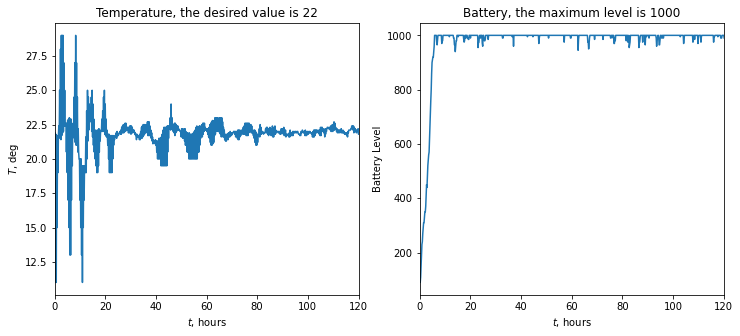

In [4]:
sampling_interval, X, Battery, Harvested_Energy, Transmission_Energy = system.simulate_with_random_policy(0.15,final_time)

system.draw_temperature_battery(sampling_interval,X,Battery,
                         title1 = 'Temperature, the desired value is 22', 
                         title2 = 'Battery, the maximum level is 1000',
                         xlabel1 = '$t$, hours', ylabel1 = '$T$, deg', 
                         xlabel2 = '$t$, hours', ylabel2 = 'Battery Level')

We can see that the battery was almost full. However, the temperature control is very bad.

Now we design the **optimal policy** using the *Reinforcement Learning* approach. We obtain the policy by solving the Bellman Equations using the ***value iteration algorithm***.

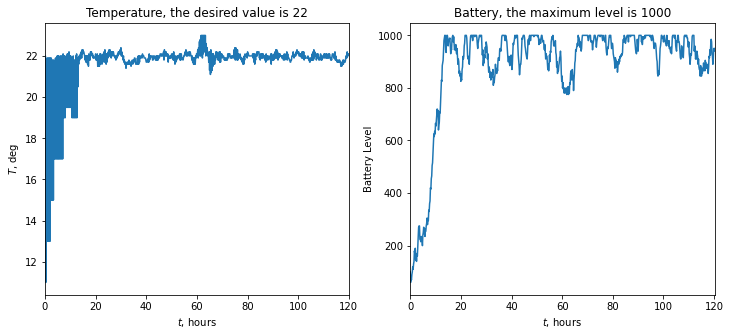

In [5]:
#Since the state space is quite large (because the total model is very complicated and contains a lot of states),
#the algorithm may work up to 30 hours (depending on the number of steps).

#opt_policy = bm.value_iteration_algorithm(system,discount_factor=0.95,balance_parameter=3,N_steps=2)

#then instead of calcuation of it above, we load precalculated optimal policy

opt_policy = np.load('opt_policy.npy')
sampling_interval, X, Battery, Harvested_Energy, Transmission_Energy = system.simulate(opt_policy,final_time)

system.draw_temperature_battery(sampling_interval,X,Battery,
                         title1 = 'Temperature, the desired value is 22', 
                         title2 = 'Battery, the maximum level is 1000',
                         xlabel1 = '$t$, hours', ylabel1 = '$T$, deg', 
                         xlabel2 = '$t$, hours', ylabel2 = 'Battery Level')

We see that although we had some transients zone in the beginning, the trajectory is stabilized. The energy consumption is very good as well. 

## Policy interpretation

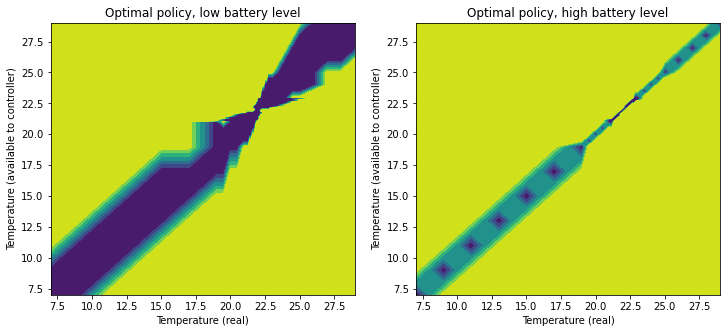

In [6]:
import matplotlib.pyplot as plt

X1, X2 = np.meshgrid(system.X_ss+system.xd, system.X_ss+system.xd)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.set_title('Optimal policy, low battery level')
ax1.contourf(X1, X2, opt_policy[:,:,10,3,4])
ax1.set_xlabel('Temperature (real)')
ax1.set_ylabel('Temperature (available to controller)')
        
ax2.set_title('Optimal policy, high battery level')
ax2.contourf(X1, X2, opt_policy[:,:,45,3,4])
ax2.set_xlabel('Temperature (real)')
ax2.set_ylabel('Temperature (available to controller)') 
plt.show()

Yellow color: '**transmit**', Blue color: '**not transmit**'

When the temperature on the controller side is close to the real one (the point is on the diagonal), then no reason to transmit. When the difference becomes larger, the decision is based on the battery level. If it is low, we should save more energy, and the 'non-transmission' zone becomes larger (left figure). If the battery level is high, the sensor transmits immediately when the controller information differs from the real one (right figure).